<a href="https://colab.research.google.com/github/aadityajha/Stock_Predict/blob/main/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2


In [19]:

# Load your CSV file
df = pd.read_csv('/content/cbbl.csv')  # Replace 'your_file.csv' with your file name

# Consider 'Close' column for prediction
data = df['Close'].values.reshape(-1, 1)




Epoch 1/15
1/1 [==============================] - 4s 4s/step - loss: 0.6398
Epoch 2/15
1/1 [==============================] - 0s 51ms/step - loss: 0.4724
Epoch 3/15
1/1 [==============================] - 0s 52ms/step - loss: 0.3452
Epoch 4/15
1/1 [==============================] - 0s 54ms/step - loss: 0.1962
Epoch 5/15
1/1 [==============================] - 0s 56ms/step - loss: 0.0839
Epoch 6/15
1/1 [==============================] - 0s 65ms/step - loss: 0.0514
Epoch 7/15
1/1 [==============================] - 0s 56ms/step - loss: 0.1243
Epoch 8/15
1/1 [==============================] - 0s 59ms/step - loss: 0.1366
Epoch 9/15
1/1 [==============================] - 0s 54ms/step - loss: 0.0633
Epoch 10/15
1/1 [==============================] - 0s 55ms/step - loss: 0.0435
Epoch 11/15
1/1 [==============================] - 0s 60ms/step - loss: 0.0445
Epoch 12/15
1/1 [==============================] - 0s 55ms/step - loss: 0.0571
Epoch 13/15
1/1 [==============================] - 0s 56ms/step

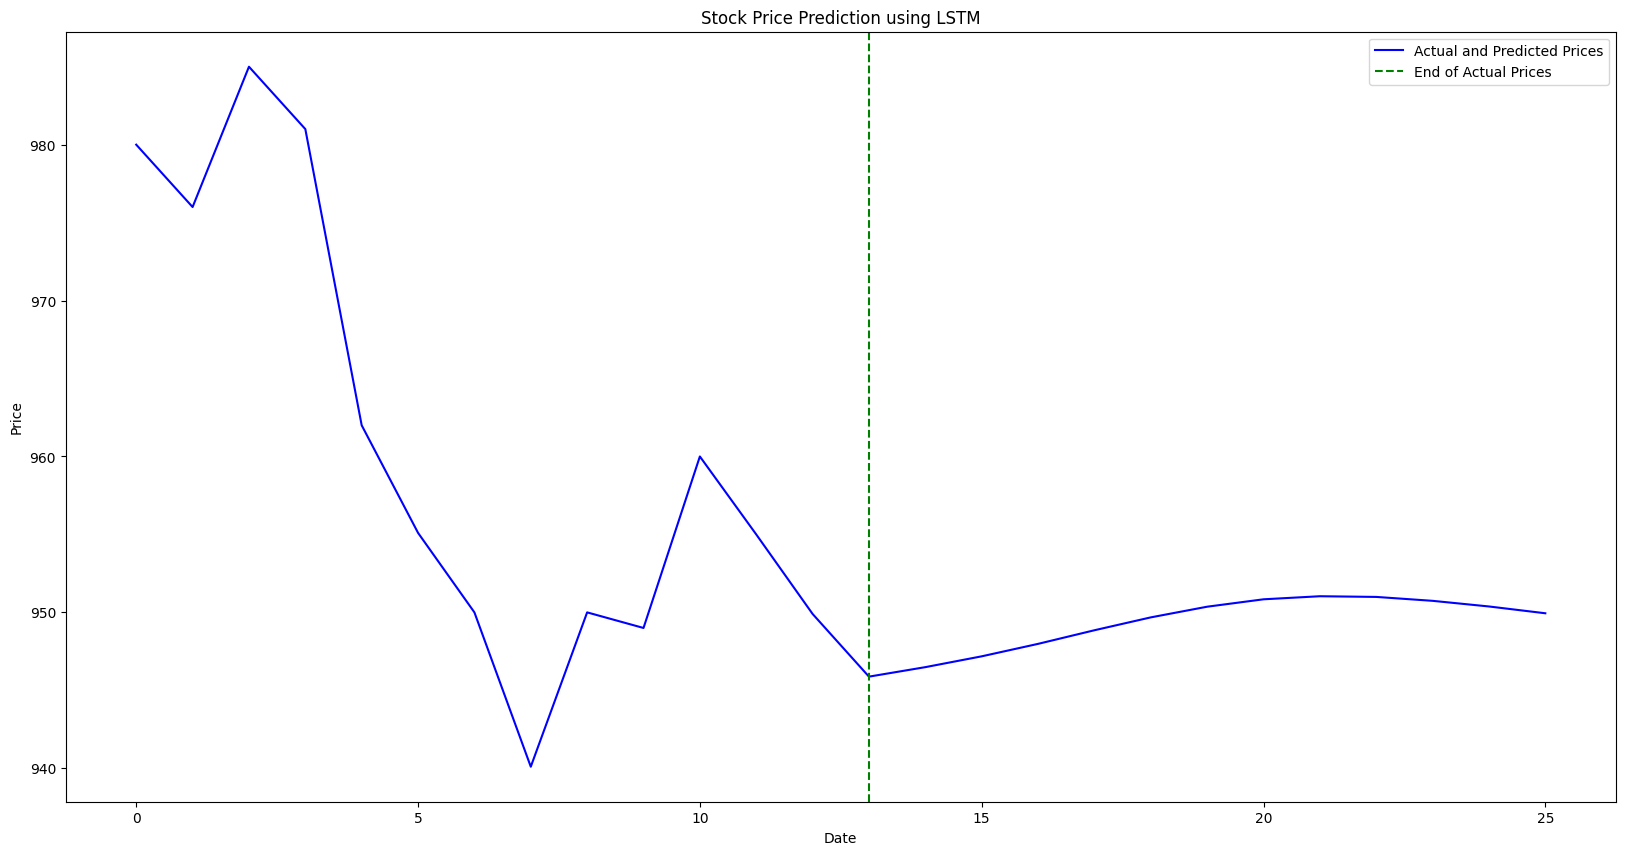

In [20]:

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Adding Moving Averages as additional features
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()

# Dropping NaN values after calculating moving averages
df.dropna(inplace=True)

# Update data with additional features
data_with_features = df[['Close', 'MA_7', 'MA_30']].values

# Define a function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Choose sequence length
sequence_length = 50

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=70, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=70))
model.add(Dropout(0.2))
model.add(Dense(units=1, kernel_regularizer=l2(0.01)))

model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32)

# Predict on the test set
predicted_data = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_data)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Concatenate actual and predicted prices for continuous chart
combined_prices = np.concatenate((actual_prices, predicted_prices), axis=0)

# Plotting the results
plt.figure(figsize=(20, 10))
plt.plot(combined_prices, color='blue', label='Actual and Predicted Prices')
plt.axvline(x=len(actual_prices), color='green', linestyle='--', label='End of Actual Prices')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 21ms/step


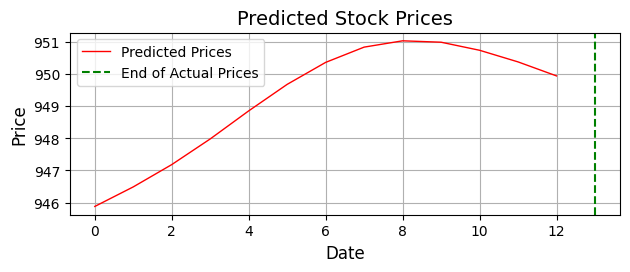

In [21]:
 #Predict future prices
future_predictions = []
last_sequence = scaled_data[-sequence_length:].reshape((1, sequence_length, 1))

for _ in range(15):  # Predict the next 15 days
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1, 0] = next_pred

# Inverse transform the predicted prices to get actual prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate date range for the future predictions
last_date = pd.to_datetime(df['Date']).max()
date_range = pd.date_range(start=last_date, periods=10)

# Convert the date range to a list of strings
date_strings = [str(date) for date in date_range]

# Plotting Predicted Prices
plt.subplot(2, 1, 2)
plt.plot(predicted_prices, color='red', label='Predicted Prices', linewidth=1)
plt.axvline(x=len(actual_prices), color='green', linestyle='--', label='End of Actual Prices')
plt.title('Predicted Stock Prices', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()